In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchmetrics.functional import dice
from torchmetrics.functional.classification import accuracy, binary_f1_score, precision_recall
from torchmetrics.classification import BinaryConfusionMatrix
import torch.nn.functional as Fn
from sklearn.metrics import precision_score, precision_recall_fscore_support
import nibabel as nib
import torch 
import seaborn as sns
from tqdm import tqdm
import os
from skimage import measure
from skimage import io

In [2]:
from glasses.interpretability import GradCam, SaliencyMap
from torchvision.transforms import Normalize
import cv2
import sys
import os

# Get the current directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to the Python path
sys.path.append(parent_dir)

In [3]:
def read_and_normalize(path):
    img = io.imread(path)
    img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img

In [6]:
import importlib

In [4]:
device="cpu"

In [7]:
from boundary_aware import siamese_unet
importlib.reload(siamese_unet)

<module 'boundary_aware.siamese_unet' from '/home/prateek/ms_change_detection/boundary_aware/siamese_unet.py'>

In [8]:
def check_keys(model, pretrain_path):
    # Check for matching keys
    pretrain = torch.load(pretrain_path, map_location=torch.device('cpu'))
    pretrained_keys = set(pretrain.keys())
    model_keys = set(model.state_dict().keys())

    missing_keys = model_keys - pretrained_keys
    unexpected_keys = pretrained_keys - model_keys

    if len(missing_keys) > 0:
        print("Missing keys in Siamese network:", missing_keys)
    else: 
        print("No Missing keys")

    if len(unexpected_keys) > 0:
        print("Unexpected keys in pre-trained UNet:", unexpected_keys)
    else:
        print("No unexpected keys")

In [9]:
model = siamese_unet.SiameseNetwork(1,1, aspp=False)
path = "../saved_models/siam_b_unet_f05_f05_pre.pt"
check_keys(model, path)

No Missing keys
No unexpected keys


In [10]:
model.load_state_dict(torch.load('../saved_models/siam_b_unet_f05_f05_pre.pt', map_location=torch.device(device)), strict=False)
model.to(device)
print("ok")

ok


In [39]:
from boundary_aware import ba_interpret
importlib.reload(ba_interpret)

<module 'boundary_aware.ba_interpret' from '/home/prateek/ms_change_detection/boundary_aware/ba_interpret.py'>

In [40]:
patient_id = "58"
instance= "0"
slc = 78
orig_dir = "/home/prateek/from_kipchoge/ms_project/change_balcrop256/"
# orig_dir = "/home/prateek/from_kipchoge/ms_project/open_ms_data/slice_data/"
# test_img1 = torch.from_numpy(read_and_normalize(os.path.join(orig_dir,"A",f"open_ms_{patient_id}_{instance}_{slc}.png")))
# test_img2 = torch.from_numpy(read_and_normalize(os.path.join(orig_dir,"B",f"open_ms_{patient_id}_{instance}_{slc}.png")))
test_img1 = torch.from_numpy(read_and_normalize(os.path.join(orig_dir,"A",f"test_sub-ID{patient_id}_{instance}_{slc}.png")))
test_img2 = torch.from_numpy(read_and_normalize(os.path.join(orig_dir,"B",f"test_sub-ID{patient_id}_{instance}_{slc}.png")))
labels = torch.from_numpy(read_and_normalize(os.path.join(orig_dir,"label",f"test_sub-ID{patient_id}_{instance}_{slc}.png")))
print(torch.sum(labels))

tensor(40.2784)


In [41]:
# apply preprocessing
x1 =  test_img1.unsqueeze(0).unsqueeze(0).requires_grad_(True).to(device)
x2 = test_img2.unsqueeze(0).unsqueeze(0).requires_grad_(True).to(device)
# Check the type of x1 and x2
outputs = model.interpret([x1,x2],probe_encoder=True, using=ba_interpret.GradCamSiam()).show()

/home/prateek/anaconda3/envs/glasses/lib/python3.8/site-packages/glasses/interpretability/utils.py:21: RuntimeWarning: invalid value encountered in divide
  cam /= np.max(cam)  # Normalize between 0-1
/home/prateek/anaconda3/envs/glasses/lib/python3.8/site-packages/glasses/interpretability/utils.py:23: RuntimeWarning: invalid value encountered in cast
  cam = np.uint8(cam * 255.0)


In [18]:
def plot_cam(cam_tuples, pred_mask, true_mask, figsize=(6, 12)):
    """
    Plot a list of tuples of CAM images with no whitespace between figures and a large figsize.

    Args:
        cam_tuples (list of tuples): List of tuples where each tuple contains two CAM images (cam1, cam2).
        figsize (tuple): Size of the figure.
    """
    num_tuples = len(cam_tuples)+1
    fig, axes = plt.subplots(num_tuples, 2, figsize=figsize)
    
    for i, (cam1, cam2) in enumerate(cam_tuples):
        ax1, ax2 = axes[i] if num_tuples > 1 else axes  # Handle the case with only one tuple
        ax1.imshow(cam1)
        ax1.axis('off')  # Turn off axis
        ax2.imshow(cam2)
        ax2.axis('off')  # Turn off axis
    ax1, ax2 = axes[-1]  # Get the last row
    ax1.imshow(pred_mask)
    ax1.axis('off')  # Turn off axis
    ax2.imshow(true_mask)
    ax2.axis('off')  # Turn off axis
    
    plt.subplots_adjust(wspace=0, hspace=0)  # Remove whitespace between figures
    plt.show()

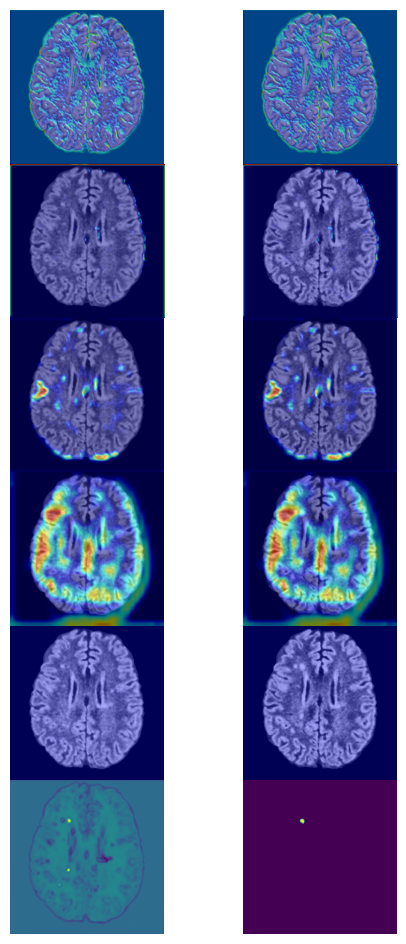

In [42]:
cams = outputs['cams']
predicted = outputs['predicted'].reshape(256,256)
boundary = outputs['boundary'].reshape(256,256)
plot_cam(cams, predicted, labels)